# Intro to PyMC codebase

Tags: Aesara, AePPL, PyMC, RandomVariable, Distribution, Model, logp

**Authors:** [Ricardo Vieira](https://github.com/ricardoV94) and [Juan Orduz](https://juanitorduz.github.io/)

For a summary overview please see [Architecture.md](https://github.com/pymc-devs/pymc/blob/main/ARCHITECTURE.md)

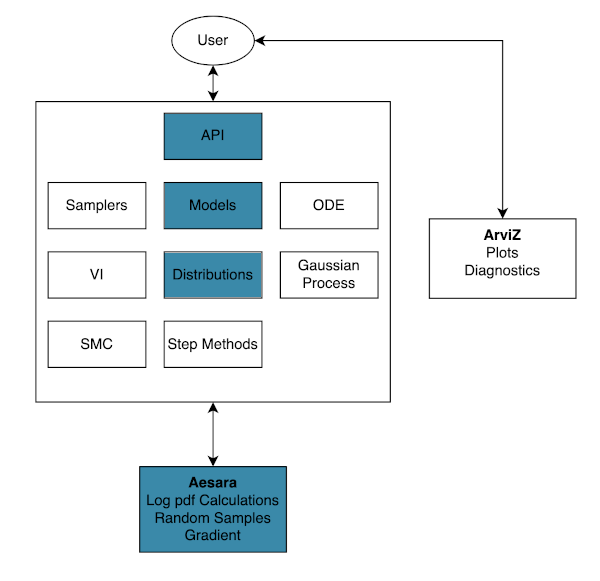



## Prepare Notebook

Let us first import the required libraries.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import aesara
import aesara.tensor as at

import pymc as pm
aesara.__version__, pm.__version__

('2.5.1', '4.0.0b6')

## Intro to Aesara

We start by looking into [aesara](https://github.com/aesara-devs/aesara/). According to their documentation

> Aesara is a Python library that allows one to define, optimize, and efficiently evaluate mathematical expressions involving multi-dimensional arrays.

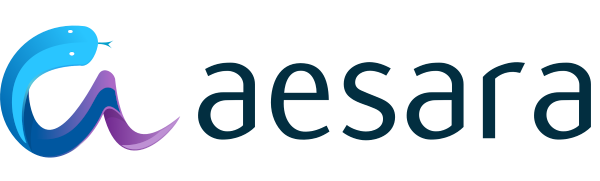

### A simple example

To begin, we start defining some aesara tensors and perform some basic operations.

In [2]:
x = at.scalar(name="x")
y = at.vector(name="y")

print(f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
""")


x type: TensorType(float64, ())
x name = x
---
y type: TensorType(float64, (None,))
y name = y



In [3]:
z = x + y
z.name = "x + y"
w = at.log(z)
w.name = "log(x + y)"

We can use the [`aesara.dprint`](https://aesara.readthedocs.io/en/latest/library/index.html#aesara.dprint) function to print the computational graph of the given tensor.

In [4]:
aesara.dprint(obj=w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


The aesara function [`aesara.function`](https://aesara.readthedocs.io/en/latest/library/compile/function.html#aesara.compile.function.function) is used to define a callable object so that we can push values trough the graph.

In [5]:
# we compile the graph with numba (conda install -c numba numba)
f = aesara.function(inputs=[x, y], outputs=w, mode="NUMBA")

Let's run some concrete values.

In [6]:
# keyword arguments only valid for named variables
f(x=0, y=[1, np.e])

array([0., 1.])

Sometimes we just want to debug, we can use `eval` for that:

In [7]:
w.eval({x: 0, y:[1, np.e]})

array([0., 1.])

You can set intermediate values as well

In [8]:
# You can set intermediate values as well
w.eval({z: [1, np.e]})

array([0., 1.])

### What is in an Aesara graph?

The following diagram shows the basic structure of an Aesara graph.

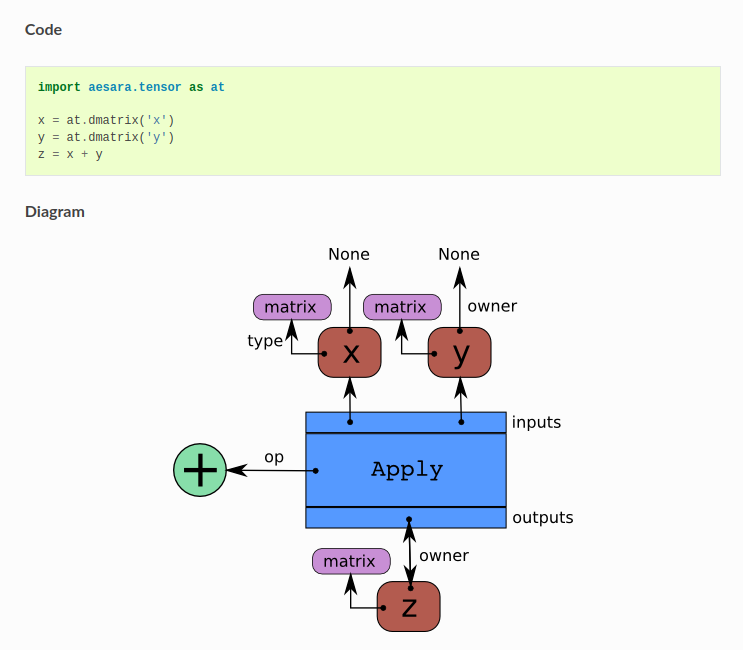

We can can make these concepts more tangible trough the example above: 

In [9]:
print(f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
""")


z type: TensorType(float64, (None,))
z name = x + y
z owner = Elemwise{add,no_inplace}(InplaceDimShuffle{x}.0, y)
z owner inputs = [InplaceDimShuffle{x}.0, y]
z owner op = Elemwise{add,no_inplace}
z owner output = [x + y]



The following sniped of code helps us to understand these concepts by going through the computational graph.

In [10]:
from aesara.tensor.elemwise import Elemwise

stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type TensorType(float64, (None,))
 > Op is Elemwise{log,no_inplace}
 > Input 0 is x + y
---
Checking variable x + y of type TensorType(float64, (None,))
 > Op is Elemwise{add,no_inplace}
 > Input 0 is InplaceDimShuffle{x}.0
 > Input 1 is y
---
Checking variable InplaceDimShuffle{x}.0 of type TensorType(float64, (1,))
 > Op is InplaceDimShuffle{x}
 > Input 0 is x
---
Checking variable y of type TensorType(float64, (None,))
 > y is a root variable
---
Checking variable x of type TensorType(float64, ())
 > x is a root variable


Note that this is very similar to the output of the  [`aesara.dprint`](https://aesara.readthedocs.io/en/latest/library/index.html#aesara.dprint) function introduced above.

In [11]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


### Graph manipulation 101

Now, we describe how to manipulate the computational graph. We continue with our tensors above to illustrate how to do it.

In [12]:
# get input tensors
list(aesara.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an `exp` before the `log` (to get the identity function).

In [13]:
parent_of_w = w.owner.inputs[0] # get z tensor
new_parent_of_w = at.exp(parent_of_w) # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not change:

In [14]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'   
 |Elemwise{add,no_inplace} [id B] 'x + y'   
   |InplaceDimShuffle{x} [id C] ''   
   | |x [id D]
   |y [id E]


To modify the graph we need to use the [`aesara.clone_replace`](https://aesara.readthedocs.io/en/latest/library/index.html?highlight=clone_replace#aesara.clone_replace) function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [15]:
new_w = aesara.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "exp(log(x + y))"
aesara.dprint(new_w)

Elemwise{log,no_inplace} [id A] 'exp(log(x + y))'   
 |Elemwise{exp,no_inplace} [id B] 'exp(x + y)'   
   |Elemwise{add,no_inplace} [id C] 'x + y'   
     |InplaceDimShuffle{x} [id D] ''   
     | |x [id E]
     |y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [16]:
new_w.eval({x: 0, y:[1, np.e]})

array([1.        , 2.71828183])

### Aesara is clever!
Note that aesara is clever enough to omit the `exp` and `log` unnecessary composition.

In [17]:
f = aesara.function(inputs=[x, y], outputs=new_w, mode="JAX")

aesara.dprint(f)

Elemwise{add,no_inplace} [id A] 'x + y'   1
 |InplaceDimShuffle{x} [id B] ''   0
 | |x [id C]
 |y [id D]


/Users/juanitorduz/opt/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")


In [18]:
f(x=0, y=[1, np.e])

DeviceArray([1.        , 2.71828183], dtype=float64)

## Aesara RandomVariables

Now that we have seen aesara's basics we want to move in the direction of random variables. Here are the modules we want to cover:

* [Random Module](https://github.com/aesara-devs/aesara/tree/main/aesara/tensor/random)
* [RandomVariable Op](https://github.com/aesara-devs/aesara/blob/main/aesara/tensor/random/op.py)
* [Random Variables](https://github.com/aesara-devs/aesara/blob/main/aesara/tensor/random/basic.py)

How To generate random numbers in `numpy`?

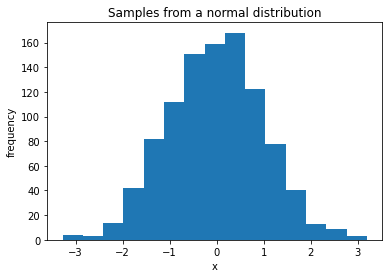

In [19]:
rng = np.random.default_rng()

a = rng.normal(loc=0, scale=1, size=1000)

fig, ax = plt.subplots()
ax.hist(a, bins=15)
ax.set(
    title="Samples from a normal distribution", xlabel="x", ylabel="frequency"
);

Now let's do it in aesara.

In [20]:
x = at.random.normal(loc=0.0, scale=1.0, size=None, name="x")

print(f"""
x type: {x.type}
x name = {x.name}
"""
)


x type: TensorType(float64, ())
x name = x



In [21]:
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1639444A0>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0.0} [id E]
 |TensorConstant{1.0} [id F]


Inputs are always in the following order:
1. rng shared variable
2. size
3. dtype (number code)
4. arg1
5. arg2
6. argn

### Some meta-properties worth knowing about

The `op` of `x`'s `owner` is:

In [22]:
op = x.owner.op

op

In [23]:
print(f"""
op ndim_supp    = {op.ndim_supp}        (Dimension of draws (0=scalar, 1=vector, 2=matrix, etc.))
op ndims_params = {op.ndims_params}   (Dimension of each parameter)
op.dtype        = {op.dtype}
""")


op ndim_supp    = 0        (Dimension of draws (0=scalar, 1=vector, 2=matrix, etc.))
op ndims_params = (0, 0)   (Dimension of each parameter)
op.dtype        = floatX



# PyMC

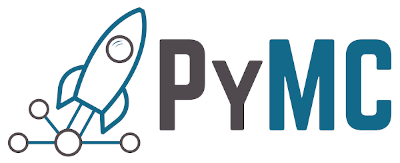

## Distributions are just RandomVariables

**Source code**
* [PyMC [rev 1005d20b3c]](https://github.com/pymc-devs/pymc/tree/1005d20b3c12d9b9a424c069f6a0f9962d73c41d)
* [Distributions module](https://github.com/pymc-devs/pymc/tree/main/pymc/distributions)
* [Distribution class](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/distribution.py)
    * See issue [#5308](https://github.com/pymc-devs/pymc/issues/5308)
* [Discrete distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/discrete.py)
* [Continuous distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/continuous.py)
* [Multivariate distributions](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/multivariate.py)

**Guide**
* [Distribution developer guide](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/docs/source/contributing/developer_guide_implementing_distribution.md)

In [24]:
x = pm.Normal.dist(mu=0, tau=2, shape=3)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] ''   
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1639BD740>) [id B]
 |TensorConstant{(1,) of 3} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{0.7071067811865476} [id F]


In [25]:
x.eval(), x.eval()

(array([-0.49026955, -1.57065844, -0.04282467]),
 array([-0.49026955, -1.57065844, -0.04282467]))

In [26]:
with pm.Model() as model:
    x = pm.Normal("x", mu=np.array([0, 0]), tau=np.array([1, 2]), size=2)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomStateSharedVariable(<RandomState(MT19937) at 0x1639AA940>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1.       ...70710678]} [id F]


In [27]:
# Variables are already seeded, but we might change this behavior in the future
x.eval(), x.eval()

(array([-0.87629932,  1.07309697]), array([-0.87629932,  1.07309697]))

In [28]:
# The CORRECT way to draw values is to use `pm.draw`
pm.draw(x, draws=2)

array([[-0.87629932,  1.07309697],
       [-0.16366472,  1.75279923]])

## What is going on behind the scenes?

**Source code**
* [Model module](https://github.com/pymc-devs/pymc/blob/main/pymc/model.py)

In [29]:
model.basic_RVs

[x]

In [30]:
aesara.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'   
 |RandomStateSharedVariable(<RandomState(MT19937) at 0x1639AA940>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1.       ...70710678]} [id F]


In [31]:
# Manual variable registration
with pm.Model() as model:
    # my_x = pm.Normal("x", 0, tau=5)
    my_x = pm.Normal.dist(0, 1)
    model.register_rv(
        rv_var=my_x,
        name="my_x",
        data=None,
        total_size=None,
        dims=None,
        transform=None,
        initval="prior",
    )
model.rvs_to_values

{my_x: my_x}

## Enough with Random Variables, I want to see some (log)probabilities!

**Source code**
* [PyMC logprob](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/pymc/distributions/logprob.py)
* [Aeppl logprob](https://github.com/aesara-devs/aeppl/blob/2019114d231d8d3d96acc284fe0e6ee42d89c912/aeppl/logprob.py)

In [32]:
point = model.compute_initial_point()
point

AttributeError: 'Model' object has no attribute 'compute_initial_point'

In [ ]:
model.point_logps(point)

In [33]:
from aeppl.logprob import _logprob

In [ ]:
_logprob.registry

In [35]:
x = pm.Normal.dist(size=2)
x.owner.op

In [36]:
x_logp = _logprob(x.owner.op, ([0, 0],), *x.owner.inputs)
aesara.dprint(x_logp)

Check{sigma > 0} [id A] ''   
 |Elemwise{sub,no_inplace} [id B] ''   
 | |Elemwise{sub,no_inplace} [id C] ''   
 | | |Elemwise{mul,no_inplace} [id D] ''   
 | | | |InplaceDimShuffle{x} [id E] ''   
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G] ''   
 | | |   |Elemwise{true_div,no_inplace} [id H] ''   
 | | |   | |Elemwise{sub,no_inplace} [id I] ''   
 | | |   | | |TensorConstant{(2,) of 0} [id J]
 | | |   | | |InplaceDimShuffle{x} [id K] ''   
 | | |   | |   |TensorConstant{0} [id L]
 | | |   | |InplaceDimShuffle{x} [id M] ''   
 | | |   |   |TensorConstant{1.0} [id N]
 | | |   |InplaceDimShuffle{x} [id O] ''   
 | | |     |TensorConstant{2} [id P]
 | | |InplaceDimShuffle{x} [id Q] ''   
 | |   |Elemwise{log,no_inplace} [id R] ''   
 | |     |Elemwise{sqrt,no_inplace} [id S] ''   
 | |       |TensorConstant{6.283185307179586} [id T]
 | |InplaceDimShuffle{x} [id U] ''   
 |   |Elemwise{log,no_inplace} [id V] ''   
 |     |TensorConstant{1.0} [id N]
 |All 

In [37]:
x_logp.eval()

array([-0.91893853, -0.91893853])

In [38]:
# Helper friendly pymc function to access logp
# Takes RV + value as input
pm.logp(x, [0, 0]).eval()

array([-0.91893853, -0.91893853])

In [ ]:
# What about other types of Ops?
try:
    y = at.cumsum(x)
    pm.logp(y, [1, 1])
except NotImplementedError as err:
    print(err)

Note: A similar dispatch strategy is used for `logcdf` and `get_moment`

## What is the deal with those value variables in the model?

* RVs for random draws
* Value variables for logprob evaluations

In [39]:
# RV and value variables can be observed in these scipy operations
(
    scipy.stats.norm(0, 1),  # Equivalent to rv = pm.Normal("rv", 0, 1)
    rv.rvs(5),               # Equivalent to rv_draw = pm.draw(rv, 5)
    rv.logpdf(1.25),         # Equivalent to rv_logp = pm.logp(rv, .125)
)

NameError: name 'rv' is not defined

In [40]:
with pm.Model() as m:
    sigma = pm.HalfNormal("sigma")
    x = pm.Normal("x", 0, sigma=sigma)

In [41]:
# Each model RV is related to a "value variable"
m.rvs_to_values

{sigma: sigma_log__, x: x}

In [42]:
m.value_vars

[sigma_log__, x]

In [43]:
# These just an input variable (constants inputs if observed)
# used in the logp graph
aesara.dprint(m.value_vars[0])

sigma_log__ [id A]


In [44]:
logp_graph = at.stack(m.logpt(sum=False))

In [45]:
sigma_value = m.rvs_to_values[sigma]
x_value = m.rvs_to_values[x]
logp_graph.eval({sigma_value: -10, x_value:0})

array([-10.22579135,   9.08106147])

In [46]:
# model compile_logp is a helpers that creates a compiled aesara function
# of the model logp, which takes a dictionary of {value variable name : value} as inputs
m.compile_logp(sum=False)({"sigma_log__": -10, "x": 0})

[array(-10.22579135), array(9.08106147)]

## Some useful Model methods to know about

In [47]:
with pm.Model() as m:
    mu = pm.Normal("mu", initval="prior")
    sigma = pm.HalfNormal("sigma", size=3, initval=[1, 2, 3])
    y = pm.Normal("y", mu, sigma, observed=[1, 1, 1])

In [48]:
# initial points
m.compute_initial_point(seed=314)

AttributeError: 'Model' object has no attribute 'compute_initial_point'

In [49]:
# logp
logp_graph = m.logpt(vars=[mu, sigma], jacobian=False, sum=False)
logp_fn = m.compile_fn(logp_graph)
logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

[array(-0.91893853), array([-0.72579135, -0.72579135, -0.72579135])]

In [50]:
# logp
logp_fn = m.compile_logp(vars=[mu, sigma], jacobian=False, sum=False)
logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

[array(-0.91893853), array([-0.72579135, -0.72579135, -0.72579135])]

In [51]:
# dlogp
# m.dlogpt(...)
dlogp_fn = m.compile_dlogp(vars=[mu])
dlogp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

array([3.])

In [52]:
# d2logp
d2logp_fn = m.compile_d2logp(vars=[mu])
d2logp_fn({'mu': np.array(0.), 'sigma_log__': np.array([0., 0., 0.])})

array([[4.]])

## PyMC goes back and forth between the random and log-probability graphs to do cool stuff:

1. Prior predictive
1. Optimization (MAP, find_constrained_prior)
1. Sampling (Metropolis, NUTS, SMC)
1. Posterior predictive

## Integration with PyMC

* PyMC Distributions return **RandomVariables** that Aeppl can always parse to obtain a logp graph.
* PyMC SymbolicDistributions return **arbitrary Aesara Variables** that we know Aeppl can always parse to obtain a logp graph
    * See [Censored distributions](https://github.com/pymc-devs/pymc/blob/1005d20b3c12d9b9a424c069f6a0f9962d73c41d/pymc/distributions/censored.py) for an example where we return `at.clip(RandomVariable, lower, upper)`